In [1]:
#for data manipulations
import pandas as pd
from pandas.api.types import CategoricalDtype

#for numerical calculations
import numpy as np

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#for datetime manipulation
from datetime import timedelta
from datetime import datetime

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [2]:

#Machine learning library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

### load data

In [3]:
path = "/content/drive/MyDrive/conrad assignement/train.csv"
path_pred = "/content/drive/MyDrive/conrad assignement/submission.csv"

In [15]:
df=pd.read_csv(path)

In [16]:
df_pred=pd.read_csv(path_pred)

In [17]:
df_pred=df_pred[["productsGroup_key","date_key","quantitySales"]]

###Data preprocessing

Checking null values

In [7]:
df[df.isnull().any(axis=1)]

,productsGroup_key,date_key,quantitySales


Converting date column into the right type

In [18]:
df['date_key']=pd.to_datetime(df['date_key'], format='%Y%m%d')
df_pred['date_key']=pd.to_datetime(df_pred['date_key'], format='%Y%m%d')

Creating temporal features

In [19]:
df['year'] = pd.to_datetime(df['date_key']).dt.year
df['month'] = df['date_key'].dt.month
df['month_year'] = df['date_key'].dt.to_period('M')
df['day_of_week'] = df['date_key'].dt.dayofweek
day_name = {0 : 'Monday', 1 : 'Tuesday', 2 : 'Wednesday', 3 : 'Thursday', 4 : 'Friday', 5 : 'Saturday', 6 : 'Sunday'}
df['day_name'] = df['day_of_week'].map(day_name)
df['quarter'] = df['date_key'].dt.quarter
df['weekofyear'] = df['date_key'].dt.weekofyear

In [20]:
df['day'] = df['date_key'].dt.day

In [21]:
df_pred['year'] = pd.to_datetime(df_pred['date_key']).dt.year
df_pred['month'] = df_pred['date_key'].dt.month
df_pred['month_year'] = df_pred['date_key'].dt.to_period('M')
df_pred['day_of_week'] = df_pred['date_key'].dt.dayofweek
df_pred['day_name'] = df_pred['day_of_week'].map(day_name)
df_pred['quarter'] = df_pred['date_key'].dt.quarter
df_pred['weekofyear'] = df_pred['date_key'].dt.weekofyear
df_pred['day'] = df_pred['date_key'].dt.day

In [12]:
df

,productsGroup_key,date_key,quantitySales,year,month,month_year,day_of_week,day_name,quarter,weekofyear,day
0,1,2019-09-02,26784.0,2019,9,2019-09,0,Monday,3,36,2
1,1,2019-09-03,7432.0,2019,9,2019-09,1,Tuesday,3,36,3
2,1,2019-09-04,1424.0,2019,9,2019-09,2,Wednesday,3,36,4
3,1,2019-09-05,608.0,2019,9,2019-09,3,Thursday,3,36,5
4,1,2019-09-06,776.0,2019,9,2019-09,4,Friday,3,36,6
...,...,...,...,...,...,...,...,...,...,...,...
242395,297,2021-11-23,18.0,2021,11,2021-11,1,Tuesday,4,47,23
242396,297,2021-11-24,16.0,2021,11,2021-11,2,Wednesday,4,47,24
242397,297,2021-11-25,16.0,2021,11,2021-11,3,Thursday,4,47,25
242398,297,2021-11-26,16.0,2021,11,2021-11,4,Friday,4,47,26


In [22]:
df1=df.set_index("date_key")

We now wish to remove the outliers of our data in order to have accurate prediction

In [14]:
q1 = np.percentile(df.quantitySales, 25)
q2 = np.percentile(df.quantitySales, 50)
q3 = np.percentile(df.quantitySales, 75)

iqr = q3 - q1

# outlier boundaries
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["quantitySales"] < lower_bound) | (df["quantitySales"] > upper_bound)]
print(outliers.head())
df = df.drop(outliers.index)
len(outliers)

    productsGroup_key   date_key  quantitySales  year  month month_year  \
0                   1 2019-09-02        26784.0  2019      9    2019-09   
14                  1 2019-09-16        42040.0  2019      9    2019-09   
25                  1 2019-09-27        15048.0  2019      9    2019-09   
39                  1 2019-10-11        10528.0  2019     10    2019-10   
42                  1 2019-10-14        15656.0  2019     10    2019-10   

    day_of_week day_name  quarter  weekofyear  day  
0             0   Monday        3          36    2  
14            0   Monday        3          38   16  
25            4   Friday        3          39   27  
39            4   Friday        4          41   11  
42            0   Monday        4          42   14  


29560

In [23]:
X=df[["productsGroup_key","quantitySales","year","month","day_of_week","day","quarter","weekofyear","date_key"]]
X_pred=df_pred[["productsGroup_key","quantitySales","year","month","day_of_week","day","quarter","weekofyear","date_key"]]
#X=df1[["productsGroup_key","quantitySales","year","month","day_of_week","day"]]

In [24]:
df_pred

,productsGroup_key,date_key,quantitySales,year,month,month_year,day_of_week,day_name,quarter,weekofyear,day
0,1,2021-11-28,0,2021,11,2021-11,6,Sunday,4,47,28
1,1,2021-11-29,0,2021,11,2021-11,0,Monday,4,48,29
2,1,2021-11-30,0,2021,11,2021-11,1,Tuesday,4,48,30
3,1,2021-12-01,0,2021,12,2021-12,2,Wednesday,4,48,1
4,1,2021-12-02,0,2021,12,2021-12,3,Thursday,4,48,2
...,...,...,...,...,...,...,...,...,...,...,...
8311,297,2021-12-21,0,2021,12,2021-12,1,Tuesday,4,51,21
8312,297,2021-12-22,0,2021,12,2021-12,2,Wednesday,4,51,22
8313,297,2021-12-23,0,2021,12,2021-12,3,Thursday,4,51,23
8314,297,2021-12-24,0,2021,12,2021-12,4,Friday,4,51,24


### Data analysis

In [14]:
X.describe()

,productsGroup_key,quantitySales,year,month,day_of_week,day,quarter,weekofyear
count,242400.000000,2.424000e+05,242400.000000,242400.000000,242400.000000,242400.000000,242400.000000,242400.000000
mean,148.684088,4.038232e+03,2020.256877,6.890516,2.999542,15.685309,2.631506,28.252215
std,85.696190,1.015878e+04,0.698231,3.437769,1.999795,8.776865,1.124618,15.060981
min,1.000000,1.000000e+01,2019.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,75.000000,3.740000e+02,2020.000000,4.000000,1.000000,8.000000,2.000000,15.000000
50%,149.000000,1.230000e+03,2020.000000,7.000000,3.000000,16.000000,3.000000,30.000000
75%,223.000000,3.410000e+03,2021.000000,10.000000,5.000000,23.000000,4.000000,41.000000
max,297.000000,1.395774e+06,2021.000000,12.000000,6.000000,31.000000,4.000000,53.000000


From the descriptive statistics about productsGroup_key we can see that the data is balanced and that the sales are collected at the same intervals.

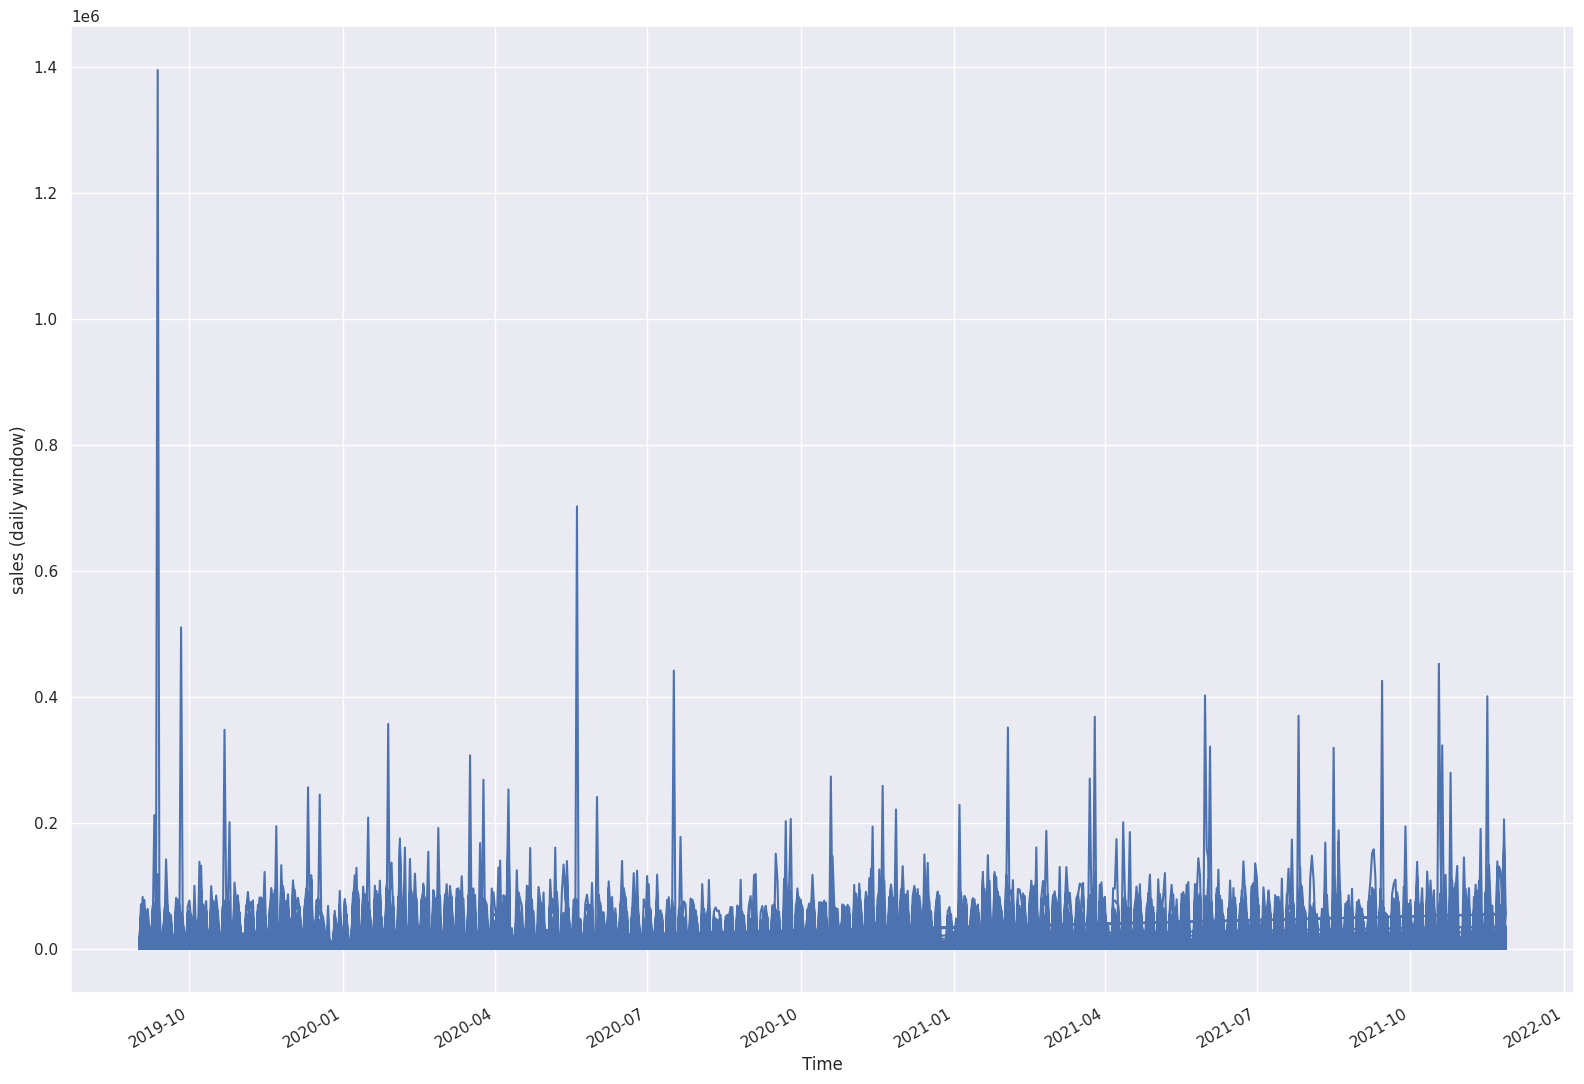

In [ ]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(df1.quantitySales)

ax.set_xlabel('Time')
ax.set_ylabel('sales (daily window)')
fig.autofmt_xdate()
plt.tight_layout()

### Data Standarisation

In [25]:
from sklearn import preprocessing
import numpy as np

In [26]:
X=X.set_index("date_key")
y=X.pop("quantitySales")
X_pred=X_pred.set_index("date_key")


In [17]:
X_pred

,productsGroup_key,quantitySales,year,month,day_of_week,day,quarter,weekofyear
date_key,,,,,,,,
2021-11-28,1,0,2021,11,6,28,4,47
2021-11-29,1,0,2021,11,0,29,4,48
2021-11-30,1,0,2021,11,1,30,4,48
2021-12-01,1,0,2021,12,2,1,4,48
2021-12-02,1,0,2021,12,3,2,4,48
...,...,...,...,...,...,...,...,...
2021-12-21,297,0,2021,12,1,21,4,51
2021-12-22,297,0,2021,12,2,22,4,51
2021-12-23,297,0,2021,12,3,23,4,51


In [27]:

y_pred=X_pred.pop("quantitySales")

In [19]:
X

,productsGroup_key,year,month,day_of_week,day,quarter,weekofyear
date_key,,,,,,,
2019-09-02,1,2019,9,0,2,3,36
2019-09-03,1,2019,9,1,3,3,36
2019-09-04,1,2019,9,2,4,3,36
2019-09-05,1,2019,9,3,5,3,36
2019-09-06,1,2019,9,4,6,3,36
...,...,...,...,...,...,...,...
2021-11-23,297,2021,11,1,23,4,47
2021-11-24,297,2021,11,2,24,4,47
2021-11-25,297,2021,11,3,25,4,47


In [28]:
# Fit the scaler
scaler = preprocessing.StandardScaler().fit(X)
#y_scaler = preprocessing.StandardScaler().fit(y.values)

In [29]:
y_scaler = preprocessing.StandardScaler().fit(np.array(y).reshape(-1, 1))

y_scaled=y_scaler.transform(np.array(y).reshape(-1, 1))

In [30]:
print(scaler.mean_)
print(scaler.scale_)

# Transform the data
X_scaled = scaler.transform(X)
X_scaled_pred = scaler.transform(X_pred)
X_scaled


[ 148.68408828 2020.25687706    6.89051568    2.99954208   15.68530941
    2.63150578   28.25221535]
[85.6960135   0.69822983  3.43776193  1.99979057  8.77684662  1.1246158
 15.06094951]


array([[-1.72334841, -1.80009075,  0.61362141, ..., -1.55925129,
         0.32766232,  0.5144287 ],
       [-1.72334841, -1.80009075,  0.61362141, ..., -1.44531515,
         0.32766232,  0.5144287 ],
       [-1.72334841, -1.80009075,  0.61362141, ..., -1.33137901,
         0.32766232,  0.5144287 ],
       ...,
       [ 1.73072125,  1.0642956 ,  1.19539526, ...,  1.06127986,
         1.21685489,  1.24479434],
       [ 1.73072125,  1.0642956 ,  1.19539526, ...,  1.175216  ,
         1.21685489,  1.24479434],
       [ 1.73072125,  1.0642956 ,  1.19539526, ...,  1.28915214,
         1.21685489,  1.24479434]])

In [31]:
X_df=pd.DataFrame(X_scaled,columns=["productsGroup_key","year","month","day_of_week","day","quarter","weekofyear"])
X_df["date_key"]=df["date_key"]
X_df=X_df.set_index("date_key")
X_df["quantitySales"]=y_scaled

In [32]:
X_df_pred=pd.DataFrame(X_scaled_pred,columns=["productsGroup_key","year","month","day_of_week","day","quarter","weekofyear"])

X_df_pred["date_key"]=df_pred["date_key"]
X_df_pred=X_df_pred.set_index("date_key")
X_df_pred["quantitySales"]=0

### Split

In [33]:
X_train=X_df[:'2021-06-01']
X_test=X_df['2021-06-01':]
test = X_df['2021-06-01':]

In [34]:
y_train=X_train.pop("quantitySales")
y_test=X_test.pop("quantitySales")

In [35]:

y_pred=X_df_pred.pop("quantitySales")

### Uncertainty distribution



##### using prophet

In [28]:
from prophet import Prophet

In [29]:
X_train['y']=y_train
X_test['y']=y_test

In [30]:
X_train['y-shifted']=X_train["y"].shift(1).fillna(0)
X_test['y-shifted']=X_test["y"].shift(1).fillna(0)

In [ ]:
X_train

,productsGroup_key,year,month,day_of_week,day,quarter,weekofyear,y,y-shifted
date_key,,,,,,,,,
2019-09-02,-1.723348,-1.800091,0.613621,-1.499928,-1.559251,0.327662,0.514429,2.239030,0.000000
2019-09-03,-1.723348,-1.800091,0.613621,-0.999876,-1.445315,0.327662,0.514429,0.334073,2.239030
2019-09-04,-1.723348,-1.800091,0.613621,-0.499823,-1.331379,0.327662,0.514429,-0.257338,0.334073
2019-09-05,-1.723348,-1.800091,0.613621,0.000229,-1.217443,0.327662,0.514429,-0.337663,-0.257338
2019-09-06,-1.723348,-1.800091,0.613621,0.500281,-1.103507,0.327662,0.514429,-0.321125,-0.337663
...,...,...,...,...,...,...,...,...,...
2021-05-28,1.730721,1.064296,-0.549926,0.500281,1.403088,-0.561530,-0.481524,-0.355381,-0.395347
2021-05-29,1.730721,1.064296,-0.549926,1.000334,1.517024,-0.561530,-0.481524,-0.395740,-0.355381
2021-05-30,1.730721,1.064296,-0.549926,1.500386,1.630961,-0.561530,-0.481524,-0.395937,-0.395740


In [31]:
X_train=X_train.reset_index()
X_test=X_test.reset_index()

In [32]:
X_train = X_train.rename(columns={'date_key': 'ds'})
X_test = X_test.rename(columns={'date_key': 'ds'})

In [ ]:
final_model = Prophet(
                      changepoint_prior_scale= 0.01,
                      seasonality_prior_scale = 0.01,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = False,
                      yearly_seasonality = False,
                      interval_width=0.95,mcmc_samples=300)
final_model.add_regressor('productsGroup_key', standardize=False)
final_model.add_regressor("y-shifted", standardize=False)
final_model.add_regressor('day_of_week', standardize=False)
final_model.add_regressor('quarter', standardize=False)
final_model.add_regressor('weekofyear', standardize=False)
final_model.fit(X_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2j8ldvu/6lhbq5uu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2j8ldvu/wewdlg1l.json
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:Command ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'info']
	error during processing Machine is not on the network
08:09:10 - cmdstanpy - INFO - CmdStan installation /usr/local/lib/python3.9/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
INFO:cmdstanpy:CmdStan installation /usr/local/lib/python3.9/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:09:10 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
INFO:cmdstanpy:Cannot determine whether version is before 2.28.
08:09:10 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=67143', 'data', 'file=/tmp/tmpd2j8ldvu/6lhbq5uu.json', 'init=/tmp/tmpd2j8ldvu/wewdlg1l.json', 'output', 'file=/tmp/tmpd2j8ldvu/prophet_modele9j4n797/prophet_model-20230403080910_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=67143', 'data', 'file=/tmp/tmpd2j8ldvu/6lhbq5uu.json', 'init=/tmp/tmpd2j8ldvu/wewdlg1l.json', 'output', 'file=/tmp/tmpd2j8ldvu/prophet_modele9j4n797/prophet_model-20230403080910_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:

08:12:52 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=67143', 'data', 'file=/tmp/tmpd2j8ldvu/6lhbq5uu.json', 'init=/tmp/tmpd2j8ldvu/wewdlg1l.json', 'output', 'file=/tmp/tmpd2j8ldvu/prophet_modele9j4n797/prophet_model-20230403080910_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpd2j8ldvu/prophet_modele9j4n797/prophet_model-20230403080910_1.csv
 console_msgs (if any):
	/tmp/tmpd2j8ldvu/prophet_modele9j4n797/prophet_model-20230403080910_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)
 

08:12:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (16.0%)
	Chain 2 had 9 divergent transitions (18.0%)
	Chain 3 had 13 divergent transitions (26.0%)
	Chain 4 had 12 divergent transitions (24.0%)
	Use function "diagnose()" to see further information.
	Chain 1 had 8 divergent transitions (16.0%)
	Chain 2 had 9 divergent transitions (18.0%)
	Chain 3 had 13 divergent transitions (26.0%)
	Chain 4 had 12 divergent transitions (24.0%)
	Use function "diagnose()" to see further information.


It seems that there s a problem with outliers or anomalies in the data that stopping the model to converge. further investigations should be performed and more tuning should be done in order to have a good model.

### Bayesian model for uncertainty distribution

#### installation

In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.8/39.8 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 

In [ ]:
!pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install theano


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 65.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668109 sha256=b5faddf095d108f11fb867d7273dbc6a54de0c8b30260f5a11a1c5b7a19f2fef
  Stored in directory: /root/.cache/pip/wheels/12/d8/36/e9b7c617ca8be398dcc48621c539d0cb1d41ff04e4367fc235
Successfully built theano


In [ ]:
!export MKL_THREADING_LAYER=GNU
!source ~/.zshrc

/bin/bash: /root/.zshrc: No such file or directory


In [ ]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"

In [ ]:
import pymc3 as pm 

lin_reg_model = pm.Model()

model_input = theano.shared(X_train)

model_output = theano.shared(y_train)

with lin_reg_model:

    alpha = pm.Normal('alpha', mu=0, sd=100, shape=(1))
    beta = pm.Normal('beta', mu=0, sd=100, shape=(1))

    s = pm.HalfNormal('s', tau=1)

    mean = alpha + beta * model_input

    y = pm.Normal('y', mu=mean , sd=s, observed=model_output)

AttributeError: ignored

#### naive bayes (baseline prediction)

In [ ]:
X_train

In [ ]:
from sklearn import linear_model
reg = linear_model.BayesianRidge(compute_score=True, n_iter=30)
reg.fit(X_train, y_train)

BayesianRidge(compute_score=True, n_iter=30)

In [ ]:
y_pred=reg.predict(X_test)

In [ ]:
y_pred

array([6503.83079272, 5581.58248077, 4659.33416883, ..., 3118.32706955,
       2196.07875761, 1273.83044566])

In [ ]:

brr_scores = -np.array(reg.scores_)

In [ ]:
import scipy.stats as stats

# define the ranges
ranges = [0.85, 0.9, 0.92, 0.95, 0.99]

# calculate the mean and standard deviation of the predicted values
y_mean, y_std = reg.predict(X_test, return_std=True)

# calculate the probabilities for each range
probs = [stats.norm.cdf((r - y_mean) / y_std) for r in ranges]


In [ ]:
import scipy.stats as stats

# calculate 95% confidence interval
ci = stats.norm.interval(0.95, loc=y_pred, scale=y_std)


In [ ]:
ci

(array([-1.67429083, -1.76506912, -1.85585007, ..., -2.00755874,
        -2.09834481, -2.18913353]),
 array([2.15970419, 2.06891535, 1.97812915, ..., 1.82645293, 1.73567185,
        1.64489343]))

In [ ]:
probs

[array([0.73266888, 0.76230142, 0.79003562, ..., 0.83188219, 0.85416068,
        0.87436312]),
 array([0.74921627, 0.77781836, 0.80446146, ..., 0.84441025, 0.86554294,
        0.88461569]),
 array([0.75568008, 0.78385948, 0.81005909, ..., 0.84924446, 0.86992038,
        0.88854552]),
 array([0.76520496, 0.79274043, 0.81826861, ..., 0.85630635, 0.87629988,
        0.89425915]),
 array([0.77757911, 0.80423981, 0.8288634 , ..., 0.86536972, 0.88446037,
        0.9015437 ])]

In [ ]:
# Convert the variable proba to a pandas DataFrame
df_proba = pd.DataFrame(probs).T


0.9, 0.92, 0.95, 0.99

In [ ]:
df_proba=df_proba.rename(columns={0: "q_0.85", 1: "q_0.9",2:"q_0.92",3:"q_0.95",4:"q_0.99"})


In [ ]:
for i in ["q_0.85", "q_0.9", "q_0.92", "q_0.95", "q_0.99"]:
  k=np.array(df_proba[i].values).reshape(-1, 1)
  df_proba[i]=y_scaler.inverse_transform(k)

In [ ]:
df_proba["date_key"]=df_pred["date_key"]

In [ ]:
results_naivebayes=df_pred[["productsGroup_key","date_key"]].join(df_proba,rsuffix="_")
results_naivebayes.pop("date_key_")

0      2021-11-28
1      2021-11-29
2      2021-11-30
3      2021-12-01
4      2021-12-02
          ...    
8311   2021-12-21
8312   2021-12-22
8313   2021-12-23
8314   2021-12-24
8315   2021-12-25
Name: date_key_, Length: 8316, dtype: datetime64[ns]

In [ ]:
results_naivebayes.to_csv('submission_uncertainty_distribution.csv', index=False)

#### Adding proba layer to our lstm

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers

In [ ]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

train_ts = series_to_supervised(X_train, 7, 1)

test_ts = series_to_supervised(X_test, 7, 1) 

In [ ]:
# split into input and outputs
train_X, train_y = train_ts.values[:, :-1], train_ts.values[:, -1]
test_X, test_y = test_ts.values[:, :-1], test_ts.values[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(180418, 1, 55) (180418,) (53453, 1, 55) (53453,)


In [ ]:
 
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')

    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [ ]:
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(72, train_X.dtype) / train_X.shape[0])

Epoch 1/40
2506/2506 [==============================] - 50s 15ms/step - loss: nan - val_loss: nan
Epoch 2/40
2506/2506 [==============================] - 32s 13ms/step - loss: nan - val_loss: nan
Epoch 3/40
2506/2506 [==============================] - 36s 14ms/step - loss: nan - val_loss: nan
Epoch 4/40
2506/2506 [==============================] - 35s 14ms/step - loss: nan - val_loss: nan
Epoch 5/40
2506/2506 [==============================] - 35s 14ms/step - loss: nan - val_loss: nan
Epoch 6/40
2506/2506 [==============================] - 32s 13ms/step - loss: nan - val_loss: nan
Epoch 7/40
2506/2506 [==============================] - 37s 15ms/step - loss: nan - val_loss: nan
Epoch 8/40
2506/2506 [==============================] - 32s 13ms/step - loss: nan - val_loss: nan
Epoch 9/40
2506/2506 [==============================] - 32s 13ms/step - loss: nan - val_loss: nan
Epoch 10/40
2506/2506 [==============================] - 34s 14ms/step - loss: nan - val_loss: nan
Epoch 11/40
2506/25

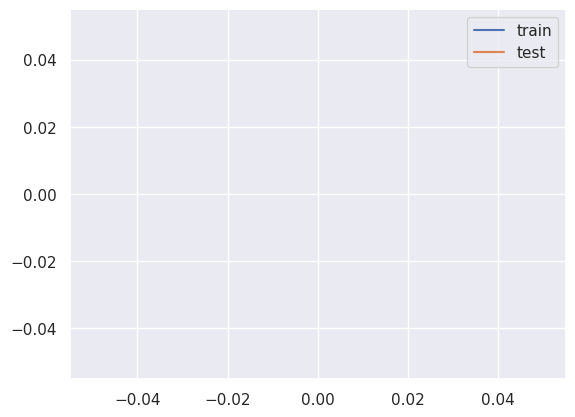

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50,return_sequences=True,  input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(25,activation='relu', activity_regularizer=regularizers.l2(1e-4)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(1))
model.add(tfp.layers.VariationalGaussianProcess( num_inducing_points=40,
        kernel_provider=RBFKernelFn(),)) 
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss) 
# fit network
#epochs=1000
history = model.fit(train_X, train_y, epochs=40, batch_size=72, validation_data=(test_X, test_y), verbose=True, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(test_X)

1671/1671 [==============================] - 11s 3ms/step


In [ ]:
y_pred

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

#### Vanilla ANN with bayesian layers

##### First architecture

First architecture had poor performance (loss)

In [36]:

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

 
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [37]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [ ]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np

 
# Convert the data to a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((
    X_train[["productsGroup_key", "year", "month", "day_of_week", "day", "quarter", "weekofyear"]].values, 
    y_train.values))

# Define the number of features and the number of product groups
num_features = 7  # productsGroup_key, year, month, day_of_week, day, quarter, weekofyear
 
# Define the model using Keras functional API
input_layer = tf.keras.Input(shape=(num_features,))

hidden_layer = tfp.layers.DenseVariational(64,make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / X_train.shape[1], activation="softmax")(input_layer)
hidden_layer = tfp.layers.DenseVariational(64, make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / X_train.shape[1],activation="softmax")(hidden_layer)

distribution_params = tf.keras.layers.Dense(units=2)(hidden_layer)
output_layer = tfp.layers.IndependentNormal(1)(distribution_params)
#output_layer = tfp.layers.DenseFlipout(1)(hidden_layer)

#output_layer = tf.keras.layers.Dense(1)(hidden_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)



# Define the loss function as the negative log likelihood
negloglik = lambda y, rv_y: -tf.reduce_mean(rv_y.log_prob(y))

# Define the optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="negative_loglikelihood")

# Train the model
history = model.fit(dataset.batch(128), epochs=2, verbose=1)


##### Second Architecture (the selected model)

In [39]:
import keras
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

    
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np

 
# Convert the data to a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((
    X_train[["productsGroup_key", "year", "month", "day_of_week", "day", "quarter", "weekofyear"]].values, 
    y_train.values))

# Define the number of features and the number of product groups
num_features = 7  # productsGroup_key, year, month, day_of_week, day, quarter, weekofyear
num_groups = y_train.nunique()
print(num_groups)
# Define the model using Keras functional API
input_layer = tf.keras.Input(shape=(num_features,))
hidden_layer = tfp.layers.DenseFlipout(64, activation="relu")(input_layer)
hidden_layer = tfp.layers.DenseFlipout(64, activation="relu")(hidden_layer)
#output_layer = tfp.layers.DenseFlipout(1)(hidden_layer)
distribution_params = keras.layers.Dense(units=2)(hidden_layer)
output_layer = tfp.layers.IndependentNormal(1)(distribution_params)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Define the loss function as the negative log likelihood
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Define the prior over the weights
prior = tfp.distributions.Normal(loc=0., scale=1.)

# Define the posterior over the weights using the variational inference
posteriors =  posterior

# Define the loss function as the negative log likelihood
negloglik = lambda y, rv_y: -tf.reduce_mean(rv_y.log_prob(y))

# Define the optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="mse")
#model.compile(optimizer=optimizer, loss=negative_loglikelihood)

# Train the model
history = model.fit(dataset.batch(128), epochs=40, verbose=2)

17168
Epoch 1/40
1479/1479 - 8s - loss: 1175.6938 - 8s/epoch - 6ms/step
Epoch 2/40
1479/1479 - 5s - loss: 1.1694 - 5s/epoch - 3ms/step
Epoch 3/40
1479/1479 - 5s - loss: 1.0582 - 5s/epoch - 3ms/step
Epoch 4/40
1479/1479 - 6s - loss: 1.0360 - 6s/epoch - 4ms/step
Epoch 5/40
1479/1479 - 6s - loss: 1.0119 - 6s/epoch - 4ms/step
Epoch 6/40
1479/1479 - 5s - loss: 1.0045 - 5s/epoch - 3ms/step
Epoch 7/40
1479/1479 - 6s - loss: 1.0075 - 6s/epoch - 4ms/step
Epoch 8/40
1479/1479 - 5s - loss: 1.0071 - 5s/epoch - 3ms/step
Epoch 9/40
1479/1479 - 7s - loss: 1.0035 - 7s/epoch - 4ms/step
Epoch 10/40
1479/1479 - 5s - loss: 1.0024 - 5s/epoch - 3ms/step
Epoch 11/40
1479/1479 - 6s - loss: 1.0020 - 6s/epoch - 4ms/step
Epoch 12/40
1479/1479 - 5s - loss: 1.0067 - 5s/epoch - 3ms/step
Epoch 13/40
1479/1479 - 6s - loss: 1.0039 - 6s/epoch - 4ms/step
Epoch 14/40
1479/1479 - 5s - loss: 1.0027 - 5s/epoch - 3ms/step
Epoch 15/40
1479/1479 - 6s - loss: 1.0006 - 6s/epoch - 4ms/step
Epoch 16/40
1479/1479 - 5s - loss: 1.000

In [40]:
# Convert the data to a TensorFlow dataset
dataset_test = tf.data.Dataset.from_tensor_slices((
    X_test[["productsGroup_key", "year", "month", "day_of_week", "day", "quarter", "weekofyear"]].values, 
    y_test.values))

In [42]:
import tensorflow_probability as tfp

# Define the number of Monte Carlo samples
num_samples = 100

# Create a function to generate predictions using Monte Carlo sampling
def predict_mc(model, dataset, num_samples):
    predicted_y = []
    for i, (x, y) in enumerate(dataset):
        print(f"Processing batch {i+1}")
        for j in range(num_samples):
            y_pred = model(x)
            predicted_y.append(y_pred)
    #predicted_y = np.concatenate(predicted_y)
    return predicted_y

# Generate predictions using Monte Carlo sampling
predicted_y = predict_mc(model, dataset_test.batch(128), num_samples)

# mean and standard deviation  
mean_predicted_y = np.mean(predicted_y, axis=0)
std_predicted_y = np.std(predicted_y, axis=0)

# Calculate the probability distribution of the uncertainty of the predictions using Monte Carlo sampling
uncertainty_distribution = tfp.distributions.Normal(loc=mean_predicted_y, scale=std_predicted_y)

# Calculate the percentiles of the uncertainty distribution
percentiles = uncertainty_distribution.percentile([0.85, 0.9, 0.92, 0.95, 0.99])

# Plot the percentiles
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for p in percentiles:
    ax.axvline(p, color='k', linestyle='--')
plt.show()


Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12


KeyboardInterrupt: ignored

#### model saving

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format


In [ ]:
!mkdir -p /content/drive/MyDrive/conrad assignement/saved_model
model.save('/content/drive/MyDrive/conrad assignement/saved_model/bayesian_ann_loss_mse')

In [ ]:
import os
new_model = tf.keras.models.load_model('/content/drive/MyDrive/conrad assignement/saved_model/bayesian_ann_loss_mse')
 
new_model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_flipout (DenseFlipout  (None, 64)               960       
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 64)               8256      
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 1)                129       
 ut)                                                             
                                                                 
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
___________________________________________________________

##### bayesian nn using pytorch for uncertainty prediction
this model couldnt be compiled because of ram limitation in google colab

In [ ]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x, y = torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).long()
print(x.shape, y.shape)

torch.Size([180425, 7]) torch.Size([180425])


In [ ]:


model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=7, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1),
)

ce_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:


kl_weight = 0.1
 
for step in range(500):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step() 


#### other failed experimentations

In [ ]:
data=pd.read_csv(path)

In [ ]:
data

,productsGroup_key,date_key,quantitySales
0,1,20190902,26784.0
1,1,20190903,7432.0
2,1,20190904,1424.0
3,1,20190905,608.0
4,1,20190906,776.0
...,...,...,...
242395,297,20211123,18.0
242396,297,20211124,16.0
242397,297,20211125,16.0
242398,297,20211126,16.0


In [ ]:
import pymc3 as pm

with pm.Model() as model: 
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope_productGroup = pm.Normal('slope_productGroup', mu=0, sigma=1)
    slope_date = pm.Normal('slope_date', mu=0, sigma=1)
     
    mu = intercept + slope_productGroup * data[:,0] + slope_date * data[:,1]
     
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=data[:,2])
    
    # Compute the posterior distribution using MCMC
    trace = pm.sample(1000, tune=1000)

quantiles = [0.85, 0.90, 0.92, 0.95, 0.99]
predictions = []
for i in range(data.shape[0]):
    new_data = {'productGroup_key': data[i,0], 'date_key': data[i,1]}
    with model:
        # Sample from the posterior distribution of the coefficients
        pp = pm.sample_posterior_predictive(trace, vars=[obs], samples=1000, var_names=['obs'])
        # Compute the desired quantiles
        prediction = [np.quantile(pp['obs'][:,j], q) for q in quantiles]
    # Append the predictions to the output array
    predictions.append([data[i,0], data[i,1], data[i,2]] + prediction)
    

the previous model didnt work because of software versions problems. we will try next bayesian nets with tensor flow